In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, classification_report, confusion_matrix

In [25]:
df = pd.read_csv("/content/drive/MyDrive/cnet_preprocessed_data.csv")

df["Label"] = df["Label"].astype(int)

# IMPORTANT: DO NOT SCALE. Dataset already partially normalized.
X = df.drop("Label", axis=1).astype(np.float32).values
y = df["Label"].values

# NORMAL DATA ONLY FOR TRAINING
X_normal = X[y == 0]

# Split normal traffic into train/val
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, X.shape)


(486713, 78) (121679, 78) (1216784, 78)


In [26]:
class TabularDataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.X[idx]  # autoencoder target = input


In [27]:
train_loader = DataLoader(TabularDataset(X_train), batch_size=2048, shuffle=True, num_workers=2)
val_loader   = DataLoader(TabularDataset(X_val),   batch_size=2048, num_workers=2)
test_loader  = DataLoader(TabularDataset(X),       batch_size=2048, num_workers=2)


In [28]:
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim=78):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DeepAutoEncoder(input_dim=X.shape[1]).to(device)

criterion = nn.L1Loss()  # MAE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=3
)


In [30]:
epochs = 25
train_loss_log = []
val_loss_log = []

for epoch in range(epochs):
    model.train()
    train_loss = 0

    for batch, _ in train_loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        output = model(batch)

        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # VALIDATION
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch, _ in val_loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch)
            val_loss += loss.item()

    scheduler.step(val_loss)

    # --- LOG LOSSES ---
    train_loss_log.append(train_loss)
    val_loss_log.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/25 | Train Loss: 31.9555 | Val Loss: 5.2478
Epoch 2/25 | Train Loss: 20.9547 | Val Loss: 4.3302
Epoch 3/25 | Train Loss: 18.6905 | Val Loss: 3.9450
Epoch 4/25 | Train Loss: 17.6416 | Val Loss: 3.7067
Epoch 5/25 | Train Loss: 17.0482 | Val Loss: 3.6358
Epoch 6/25 | Train Loss: 16.6093 | Val Loss: 3.5508
Epoch 7/25 | Train Loss: 16.2158 | Val Loss: 3.5763
Epoch 8/25 | Train Loss: 15.7833 | Val Loss: 3.2637
Epoch 9/25 | Train Loss: 14.7402 | Val Loss: 3.1884
Epoch 10/25 | Train Loss: 14.4845 | Val Loss: 2.9900
Epoch 11/25 | Train Loss: 14.1570 | Val Loss: 2.9846
Epoch 12/25 | Train Loss: 13.9771 | Val Loss: 2.8999
Epoch 13/25 | Train Loss: 13.6935 | Val Loss: 2.8639
Epoch 14/25 | Train Loss: 13.6437 | Val Loss: 2.7703
Epoch 15/25 | Train Loss: 13.4485 | Val Loss: 2.8157
Epoch 16/25 | Train Loss: 13.2744 | Val Loss: 2.8022
Epoch 17/25 | Train Loss: 13.0855 | Val Loss: 2.7251
Epoch 18/25 | Train Loss: 12.8834 | Val Loss: 2.6864
Epoch 19/25 | Train Loss: 12.6418 | Val Loss: 2.6662
Ep

In [31]:
model.eval()
recon_errors = []

with torch.no_grad():
    for batch, _ in test_loader:
        batch = batch.to(device)
        output = model(batch)
        errors = torch.mean(torch.abs(output - batch), dim=1)
        recon_errors.extend(errors.cpu().numpy())

recon_errors = np.array(recon_errors)


In [32]:
fpr, tpr, thresholds = roc_curve(y, recon_errors)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print("Optimal Threshold =", optimal_threshold)


Optimal Threshold = 0.034598615


In [33]:
y_pred = (recon_errors > optimal_threshold).astype(int)

print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

[[436913 171479]
 [112729 495663]]
              precision    recall  f1-score   support

           0       0.79      0.72      0.75    608392
           1       0.74      0.81      0.78    608392

    accuracy                           0.77   1216784
   macro avg       0.77      0.77      0.77   1216784
weighted avg       0.77      0.77      0.77   1216784



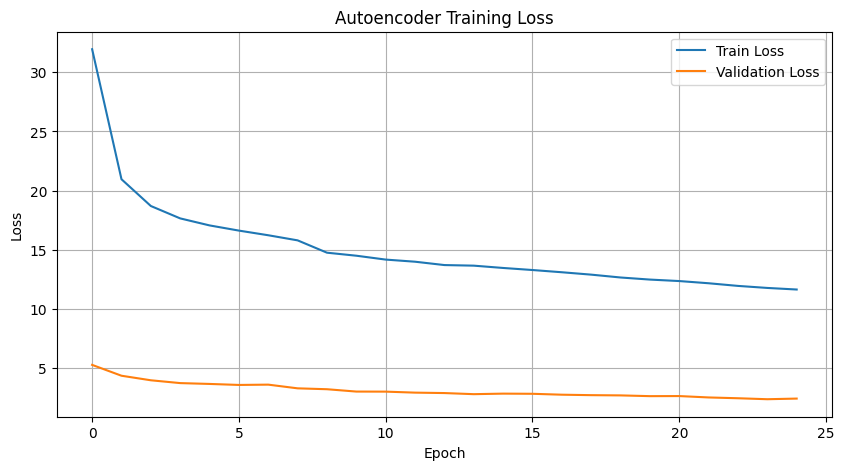

In [34]:
plt.figure(figsize=(10,5))
plt.plot(train_loss_log, label="Train Loss")
plt.plot(val_loss_log, label="Validation Loss")
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()